In [1]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
import pymysql
import matplotlib.pyplot as plt
from matplotlib import font_manager , rc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# !pip install pymysql
# 여기서 pip install 하면 requirements에 포함되는지??

In [3]:
user = 'root'
pwd = '1234'
server = 'localhost'
db_name = 'movie_review'
engine = create_engine(f'mysql+pymysql://{user}:{pwd}@{server}/{db_name}?charset=utf8', convert_unicode=True)

connect = engine.connect()

raw_data = pd.read_sql_table('raw_file',connect)
raw_data

,id,user,title,genre,score
0,63,tnen,기방도령,코미디,4
1,64,tnen,페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이,애니메이션,1
2,65,tnen,사바하,미스터리,10
3,66,tnen,글래스,드라마,10
4,67,tnen,모털 엔진,액션,10
...,...,...,...,...,...
35689,35752,dela,나이브스 아웃,미스터리,10
35690,35753,dela,헌트,액션,9
35691,35754,dela,미드소마,공포,5
35692,35755,dela,미져리,스릴러,10


In [4]:
%%time
# 10개 평가 이하 영화 제거

def refinding_df(raw_data):
    title_number_df = raw_data.groupby('title').count().sort_values('user')
#     print(title_number_df)
    title_under_10 = title_number_df[title_number_df.user <= 10]
#     print(title_under_10)
    title_under_10_list = list(title_under_10)
    
    for title in title_under_10_list:
        raw_data = raw_data[raw_data['title'] != title]
    return raw_data
    
raw_df = refinding_df(raw_data)
raw_df.shape

Wall time: 57.2 ms


(35694, 5)

In [5]:
df = raw_df.copy()
df.tail(2)

,id,user,title,genre,score
35692,35755,dela,미져리,스릴러,10
35693,35756,dela,살인마 잭의 집,드라마,6


In [6]:
df = df.drop(['id'], axis =1)
df

,user,title,genre,score
0,tnen,기방도령,코미디,4
1,tnen,페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이,애니메이션,1
2,tnen,사바하,미스터리,10
3,tnen,글래스,드라마,10
4,tnen,모털 엔진,액션,10
...,...,...,...,...
35689,dela,나이브스 아웃,미스터리,10
35690,dela,헌트,액션,9
35691,dela,미드소마,공포,5
35692,dela,미져리,스릴러,10


###  DATA 탐색

In [7]:
user_num = df.user.unique().shape[0]
movie_num = df.title.unique().shape[0]
print(f'유저의 수는 {user_num} 명이고, \n영화의 수는 {movie_num}이다')

유저의 수는 821 명이고, 
영화의 수는 5029이다


### 평점을 많이 남긴 유저 탑10

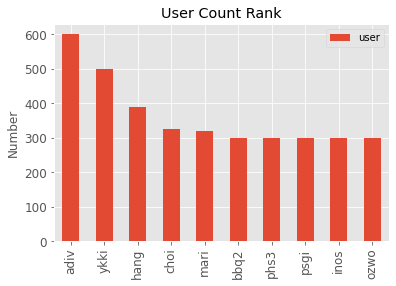

In [8]:
user_top_10 = df.user.value_counts()[:10]
plt.style.use('ggplot')
user_top_10.plot(kind='bar',title = 'User Count Rank', legend = True, fontsize='12')
plt.ylabel("Number")
plt.show()

### 유저들로 부터 평점을 많이 받은 영화 탑10

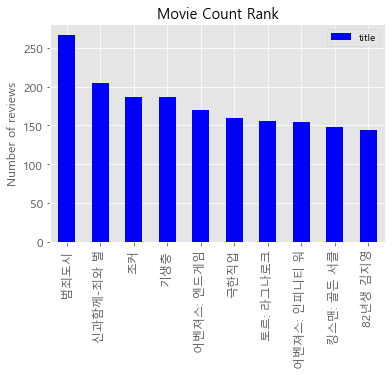

In [9]:
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
# font_name
rc('font', family = font_name)
movie_top_10 = df.title.value_counts()[:10]
movie_top_10.plot(kind='bar', title='Movie Count Rank', legend=True, fontsize=12, color='b')
plt.ylabel('Number of reviews', fontsize=12)
plt.show()
# df.title.value_counts()[:10]

### 평점 랭킹

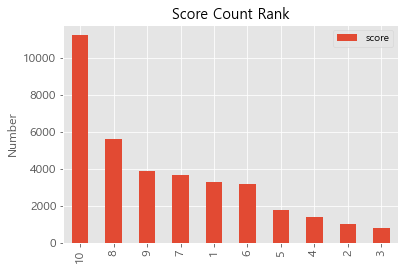

In [10]:
# df.score.value_counts()

score_ranking = df.score.value_counts()[:10]
plt.style.use('ggplot')
score_ranking.plot(kind='bar', title = 'Score Count Rank', legend = True, fontsize='12')
plt.ylabel("Number")
plt.show()

#### Colaborative Filtering
###### 1. 행렬로 만든다.
###### 2. 추천하고자 하는 유저가 입력되면 코사인 유사도를 이용하여 각 유사를 구한다.
###### 3. 추천하고자 하는 유저와 K명의 비슷한 유저들의 아이템에 대한 평점을 이용하여 t가 아직 평가하지 않은 영화의 평점을 예측해서 유저에게 추천한다.
###### 4. Validation 한다.

In [11]:
# LabelEncoder를 이용하여 수치화
def execute_labeling(column_name):
    Lec = LabelEncoder()
    df_copy = df.copy()
    labeling_data = Lec.fit_transform(df_copy[column_name].values)
    df_label = pd.DataFrame(labeling_data, columns=[column_name+"_label"], index=df_copy.index)
#     print(labeling_data)
    return df_label
df_user = execute_labeling('user')
df_title = execute_labeling('title')

print(len(df_user['user_label'].value_counts()))
print(len(df_title['title_label'].value_counts()))

df_copy = df.copy()
df_copy = df_copy.drop(df_copy.columns[[0,1]], axis = 1)
df_label = pd.concat([df_user, df_title, df_copy], axis = 1)
df_label.tail(5)

821
5029


,user_label,title_label,genre,score
35689,144,625,미스터리,10
35690,144,4879,액션,9
35691,144,1769,공포,5
35692,144,1833,스릴러,10
35693,144,2311,드라마,6


In [12]:
movie_list = list(df['title'].unique())
movie_list = sorted(movie_list, key = str)
movie_list
df_matrix = pd.DataFrame(columns=['user'] +movie_list)
df_matrix

,user,#살아있다,#아이엠히어,0.0MHz,007 골드핑거,007 나를 사랑한 스파이,007 네버 세이 네버 어게인,007 다이아몬드는 영원히,007 문레이커,007 살인번호,...,히로인 실격,히말라야,히어로,히어애프터,히트,히트맨,히트맨: 에이전트 47,힐빌리의 노래,힐즈 아이즈,"힘을 내요, 미스터 리"


In [13]:
user_num = len(df_label.user_label.unique())
movie_num = len(df_label.title_label.unique())

user_score_list = []
for num in range(0,user_num):
    user_score_list = [0 for i in range(movie_num)]
#     print(user_score_list)
    
    df_tmp = df_label[df_label['user_label'] == num]
    for j in df_tmp.index:
        user_score_list[df_tmp.loc[j]['title_label']-1] = df_tmp.loc[j]['score']
    df_matrix.loc[num]= [num] + user_score_list
# user_score_list

type(df_matrix)

pandas.core.frame.DataFrame

In [14]:
df_matrix

,user,#살아있다,#아이엠히어,0.0MHz,007 골드핑거,007 나를 사랑한 스파이,007 네버 세이 네버 어게인,007 다이아몬드는 영원히,007 문레이커,007 살인번호,...,히로인 실격,히말라야,히어로,히어애프터,히트,히트맨,히트맨: 에이전트 47,힐빌리의 노래,힐즈 아이즈,"힘을 내요, 미스터 리"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6,0,0,0,0,8
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,816,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
817,817,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
818,818,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
819,819,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### pickle를 사용 데이터프레임을 바이너리로 바꾼다.(유틸리티 행렬)

In [15]:
import pickle
file = df_matrix
directory = open('utilitymatrix', 'wb')
pickle.dump(file, directory)
directory.close()

In [16]:
user_name = list(df['user'].unique())
user_name = sorted(user_name, key = str)
user_name = pd.DataFrame(user_name)
user_name.columns = ['user_name']
file_user = user_name

directory_user = open('user_name', 'wb')
pickle.dump(file_user, directory_user)
directory_user.close()

In [17]:
f = open('utilitymatrix','rb')
utilitymatrix = pickle.load(f)
df = utilitymatrix
type(df)

pandas.core.frame.DataFrame

In [18]:
f = open('user_name','rb')
user_name = pickle.load(f)
user_name.tail(5)

,user_name
816,zltm
817,zxcb
818,zzoa
819,zzza
820,zzzz


In [19]:
df_concat = pd.concat([user_name, df], axis = 1)
df_concat

,user_name,user,#살아있다,#아이엠히어,0.0MHz,007 골드핑거,007 나를 사랑한 스파이,007 네버 세이 네버 어게인,007 다이아몬드는 영원히,007 문레이커,...,히로인 실격,히말라야,히어로,히어애프터,히트,히트맨,히트맨: 에이전트 47,힐빌리의 노래,힐즈 아이즈,"힘을 내요, 미스터 리"
0,009h,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0106,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1111,2,0,0,0,0,0,0,0,0,...,0,0,0,0,6,0,0,0,0,8
3,111o,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0
4,1432,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,zltm,816,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
817,zxcb,817,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
818,zzoa,818,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
819,zzza,819,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# 코사인 유사도를 구하는 함수를 만들어 사용
def cosine_similiarity(data_name):
    from sklearn.metrics.pairwise import cosine_distances
    similiarity = 1 - cosine_distances(data_name)
    return similiarity

cos_sim = cosine_similiarity(df)
cos_sim

array([[1.        , 0.03243512, 0.00154503, ..., 0.01109737, 0.0029239 ,
        0.00767575],
       [0.03243512, 1.        , 0.01730132, ..., 0.01818773, 0.01723863,
        0.01882476],
       [0.00154503, 0.01730132, 1.        , ..., 0.0297367 , 0.02864915,
        0.02863151],
       ...,
       [0.01109737, 0.01818773, 0.0297367 , ..., 1.        , 0.99797261,
        0.99799753],
       [0.0029239 , 0.01723863, 0.02864915, ..., 0.99797261, 1.        ,
        0.99862049],
       [0.00767575, 0.01882476, 0.02863151, ..., 0.99799753, 0.99862049,
        1.        ]])

##### 한 유저 k가 선택되면 k가 평점을 안한 영화의 평점을 예측해서 k에게 높은 것을 추천한다.
##### 다른 유저를 n명의 s 유저를 이용해서

In [40]:
class Basic(object):
    def __init__(self, user_name, neigh_num):
        self.user_name = user_name
        self.neigh_num = neigh_num
        
    #유저를 입력하면 유저의 번호를 리턴
    def convert_user_name(self):
        user_name_list = list(df_concat['user_name'].unique())
        for num in range(len(user_name_list)):
            if user_name_list[num] == self.user_name:
                user_num = num
        return user_num
    
    # target user와 유사한 유저 n명을 찾고, cosine metrics를 사용하여 이웃한 거리를 찾는다.
    def find_near_neighbor(self):
        from sklearn.neighbors import NearestNeighbors # 비지도 학습 
        user_num = Basic.convert_user_name(self)
        KNN = NearestNeighbors(n_neighbors=self.neigh_num, metric='cosine')  # 형식에 맞게 해야함 / 5을 쓰면 이웃한 5개를 찾음
        KNN.fit(df)
        
        
        similar_distance, similar_users = KNN.kneighbors(df)

        similars = {}
        # 유사한 유저간 거리
        similar_distance = similar_distance[user_num][1:]
        similars['sim_distance'] = similar_distance
        # 유사한 유저
        similar_user = similar_users[user_num][1:]
        similars['sim_users'] = list(similar_user)
        
        return similars
    
    # target 유저와 유사한 n명으로 이루워진 새로운 테이터프레임 만들고 narray 형식으로 반환
    def near_neighbors_narray(self):
        similars = Basic.find_near_neighbor(self)
        similar_users_list = similars['sim_users']
        similar_distance = similars['sim_distance']
        
        columns = list(df.columns)
        new_df = pd.DataFrame(columns = columns)
        
        for i in range(len(similar_users_list)):
            neighbor_df = df[df['user'] == similar_users_list[i]]
            neighbor_df = pd.concat([new_df, neighbor_df])
            new_df = neighbor_df
        narray = new_df.values
        narray = narray[: , 1:]
        
        return narray

In [41]:
user_neighbors = Basic('zzza', 20)
user_neighbors_narray = user_neighbors.near_neighbors_narray()
len(user_neighbors_narray)

19

In [47]:
class Calculation_rating(Basic):
    def __init__(self, user_name, neigh_num):
        Basic.__init__(self, user_name, neigh_num)
    """가중평균 값으로 아이템에 대한 target 유저의 평점을 예측"""
    def predict_rating(self):
        narray = Basic.near_neighbors_narray(self)    #narray 받음
        similars = Basic.find_near_neighbor(self)
        similiar_distances = similars['sim_distance']
        rating_list = []    # 가중평균값을 담는 리스트
        # 범위 0 ~ K-1
        for col_num in range(narray.shape[1]):
            sum = 0
            rating = 0
            for i in range(1, len(narray[:, col_num])):
                 sum += float(narray[:, col_num][i]) * float(similiar_distances[i])
            rating = sum/similiar_distances.sum()
            if rating < 0:
                rating = 0    # 만약 가중평균값이 0보다 작으면 0점으로 함
            elif rating > 10:
                rating = 10    # 만약 가중평균값이 10보다 크면 10점으로 함
            else:
                rating = int(rating)    # 평점은 정수형
            rating_list.append(rating)
        return rating_list
    """target 유저의 평점을 리스트로 변환하는 함수"""
    def original_rating(self):
        user_num = Basic.convert_user_name(self)
        # target 유저의 평점을 narray로 변환
        target_df = df[df['user'] == user_num]
        target_narray = target_df.values
        target_narray = target_narray[:, 1:]    # user column 삭제
        #narray로 변환된 target 유저의 평점을 리스트로 변환
        target_user_rating_list = []
        for i in range(target_narray.shape[1]):
            raw_rating = int(target_narray[0][i])
            target_user_rating_list.append(raw_rating)
        return target_user_rating_list

In [48]:
user_tnen = Calculation_rating('tnen', 6)
print(user_tnen)
print(user_tnen.predict_rating())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#### MSE를 평가

In [49]:
def evaluation(neigh_num):
    from sklearn.metrics import mean_squared_error
    mse = 0
    user_name_list = list(df_concat['user_name'].unique())
    
    for user_name in tqdm(user_name_list):
        cal = Calculation_rating(user_name, neigh_num)
        predict_list = cal.predict_rating()
        original_list = cal.original_rating()
        mse_onebyone = mean_squared_error(predict_list, original_list)
        mse += mse_onebyone
    mse_mean = mse / len(user_name_list)
    return mse_mean

In [26]:
mse_mean_60 = evalation(60)
mse_mean_40 = evalation(40)
mse_mean_20 = evalation(20)

for mse_mean in [mse_mean_60, mse_mean_40, mse_mean_20]:
    print(mse_mean)
    

100%|████████████████████████████████████████████████████████████████████████████████| 821/821 [10:59<00:00,  1.25it/s]

0.3772315454650482
0.3738293536949761
0.36850675340031464


In [27]:
%%time
neigh_num = [6,8,11]   # 해보면 7이 제일 좋은 값이 나옴. 
for i in neigh_num:
    neigh_num_i = evalation(i)
    print(f'이웃의 수가{i}일때 MSE의 값은 {neigh_num_i}이다.')

  0%|                                                                                          | 0/821 [00:00<?, ?it/s]

이웃의 수가6일때 MSE의 값은 0.3697737047172683이다.


  0%|                                                                                          | 0/821 [00:00<?, ?it/s]

이웃의 수가8일때 MSE의 값은 0.36628044552315236이다.


100%|████████████████████████████████████████████████████████████████████████████████| 821/821 [10:32<00:00,  1.30it/s]

이웃의 수가11일때 MSE의 값은 0.3674919329036527이다.
Wall time: 31min 3s


##### 6. 예측한 평점을 가지고 타겟유저에게 3편의 영화를 추천

In [50]:
class UBCF(Calculation_rating):
    def __init__(self, user_name, neigh_num):
        Basic.__init__(self, user_name, neigh_num)
        Calculation_rating.__init__(self, user_name, neigh_num)
        
    def recommend_movie_list(self):
        user_num = Basic.convert_user_name(self)
        predict_list = Calculation_rating.predict_rating(self)
        original_list = Calculation_rating.original_rating(self)
        all_movie_list = df.columns[1:]
        
        """
        타겟 유저의 이미 평가된 영화 이외의 영화를 추천하기 위해서 타겟 유저의 평점이 0이면 가중값을 넣고,
        그렇지 않으면 0을 넣는다.
        """
        
        temp_list = []
        for i in range(len(predict_list)):
            if int(original_list[i]) != 0:
                temp_list.append(0)
            else:
                temp_list.append(int(predict_list[i]))
        
        # 5점 이상인 영화 추천
        recommend_list_index = []
        for i in range(len(temp_list)):
            if temp_list[i] >= 5:
                recommend_list_index.append(i)
                
        # recommend_list_index로 부터 영화 제목을 str로 저장
        recommend_list_str = []
        for i in recommend_list_index:
            recommend_list_str.append(all_movie_list[i])
                
        # 전체 영화 중에서 타겟유저가 이미 평가한 영화를 제거
        already_rating_movie_num = [i for i in range(len(temp_list)) if temp_list[i] == 0]
        user_movie_list = [all_movie_list[i] for i in range(len(all_movie_list)) if i not in already_rating_movie_num]
        final_dict = {}
        final_dict['by_rating'] = recommend_list_str
        final_dict['by_delete'] = user_movie_list
        return final_dict
    
        """영화 추천 실행 함수"""
    def recommendation(self):
        import random
        user_number = Basic.convert_user_name(self)
        movie_dict = UBCF.recommend_movie_list(self)
        by_rating_list = movie_dict['by_rating']
        by_delete_list = movie_dict['by_delete']
        # 만약 추천 리스트가 3개 이상이라면 가중평균 리스트에서 3편의 영화를 추천리스트에서 추천
        # 그렇지 않으면 유저가 이미 평가했던 영화를 제외한 영화 리스트에서 추천
        if len(by_rating_list) >= 3:
            recommendation_selection = random.sample(by_rating_list, 3)
        else:
            if len(by_delete_list) >= 3 :
                recommendation_selection = random.sample(by_delete_list, 3)
            else:
                recommendation_selection = random.sample(by_delete_list, 1)
        user_name = df_concat['user_name'][user_number]    # user number를 user의 아이디로 변경
        print('{}님을 위한 추천 영화 입니다.'.format(user_name))
        print(recommendation_selection)
        return recommendation_selection


In [51]:
cf_dela = UBCF('dela',8)
final_dict = cf_dela.recommendation()
print(final_dict)

dela님을 위한 추천 영화 입니다.
['할로우 맨 2', '너의 여자친구', '쓰나미 LA']
['할로우 맨 2', '너의 여자친구', '쓰나미 LA']


In [52]:
cf_tnen = UBCF('tnen',8)
final_dict = cf_tnen.recommendation()
print(final_dict)

tnen님을 위한 추천 영화 입니다.
['너에게 나를 보낸다', '신비한 동물들과 그린델왈드의 범죄', '턱시도']
['너에게 나를 보낸다', '신비한 동물들과 그린델왈드의 범죄', '턱시도']


In [60]:
import requests
import json
url = 'https://openapi.naver.com/v1/search/movie.json?display=100&query=기방도령'
clientId = 'sDU3aQusPglxWg8tix2Q'
clientSecret = 'z00o4vOcPv'

header = {
    "X-Naver-Client-Id":clientId,
    "X-naver-Client-Secret":clientSecret
}
r = requests.get(url, headers = header)
dic = json.loads(r.text)
print(dic)

{'lastBuildDate': 'Wed, 07 Jul 2021 12:09:14 +0900', 'total': 1, 'start': 1, 'display': 1, 'items': [{'title': '<b>기방도령</b>', 'link': 'https://movie.naver.com/movie/bi/mi/basic.nhn?code=180209', 'image': 'https://ssl.pstatic.net/imgmovie/mdi/mit110/1802/180209_P42_134851.jpg', 'subtitle': 'HOMME FATALE', 'pubDate': '2019', 'director': '남대중|', 'actor': '준호|정소민|최귀화|예지원|공명|', 'userRating': '5.81'}]}


In [77]:
items = dic['items']
image = items[0]['image']

print(image)


https://ssl.pstatic.net/imgmovie/mdi/mit110/1802/180209_P42_134851.jpg


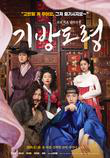

In [72]:
# from io import BytesIO
# from PIL import Image
# request_get_img = Image.open(BytesIO(requests.get(image).content))
# request_get_img

In [74]:
import urllib.request

# 다운받을 이미지 url
url = image

# 이미지 요청 및 다운로드
urllib.request.urlretrieve(url, "기방도령.jpg")

# 저장 된 이미지 확인
img = Image.open("기방도령.jpg")


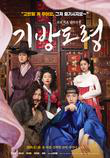

In [75]:
img